### Research
In well log lithology interpretation, the phrase "building a proper algorithm to map stringers" refers to the process of developing a systematic and accurate method to identify and characterize stringers within the geological formations encountered in a well.

Stringers typically refer to thin, elongated or discontinuous layers or veins of a specific lithology (rock type) within a larger formation. These stringers may have distinct properties or lithologies compared to the surrounding rock units, and identifying and mapping them accurately is important for understanding the geological characteristics of the subsurface.

To "build a proper algorithm" means creating a set of rules or procedures that can be applied to well log data to identify and delineate stringers. This algorithm should leverage the information provided by different well log measurements, such as gamma ray, resistivity, density, neutron porosity, etc., to detect and classify stringers based on their unique signatures.

The algorithm may involve analyzing patterns and anomalies in the well log data, using statistical methods, applying machine learning techniques, or incorporating domain-specific knowledge. The goal is to create a reliable and consistent approach that can be applied across multiple wells or sections of a well to accurately identify and map stringers in the subsurface.

By developing such an algorithm, geoscientists and reservoir engineers can gain insights into the distribution and characteristics of stringers, which can have implications for hydrocarbon reservoir quality, fluid flow behavior, and overall geological modeling and interpretation.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import pickle

In [2]:
def drop_columns(data, *args):

    '''
    function used to drop columns.
    args:: 
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''
    
    columns = []
    for _ in args:
        columns.append(_)
        
    data = data.drop(columns, axis=1)
        
    return data


def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data

In [3]:
def fill_missing_values(df):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(df.columns)
    for _ in cols:

        df[_] = np.where(df[_] == np.inf, -999, df[_])
        df[_] = np.where(df[_] == np.nan, -999, df[_])
        df[_] = np.where(df[_] == -np.inf, -999, df[_])
        
    return df


In [4]:
PWD = '/media/Data-B/my_research/Geoscience_FL/data_well_log/'

A = np.load('penalty_matrix.npy')
train = pd.read_csv(PWD + 'train.csv', sep=';')
test = pd.read_csv(PWD + 'test.csv', sep=';')

The augment_features_window function is used to concatenate feature windows in a given dataset. It takes two inputs: X, which is the input feature matrix, and N_neig, representing the number of neighboring windows to consider on each side of the current window. The function performs the following steps:

In [5]:
#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl


# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [6]:
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [7]:
class Model():

    '''
    class to lithology prediction
    '''
    
    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''
        
        self.train = train
        self.test = test

        
    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}
        
        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values
        
        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values  
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''

        

        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)
        
        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        print(f'dataframe columns: {data.columns}')
        
        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        
        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets BEFORE augmentation {traindata.shape, testdata.shape}')
 
        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)
        

        print(f'Shape of train and test datasets AFTER augmentation {traindata1.shape, testdata1.shape}')
    
        return traindata1, testdata1, lithology1, lithology_numbers

    
    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      open_test = np.zeros((len(testdata1), 12))
      
      #100 n-estimators and 10 max-depth
      model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
 
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testdata1))
      
      open_test= pd.DataFrame(open_test/split)
    
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')

                  
      if plot: 
         feature_names = pd.DataFrame(traindata1).columns
         self.plot_feat_imp(model, feature_names)

      # pickle.dump(model, open('xgboost_model.pkl', 'wb'))
      # print('The model is saved')


      return open_test, model, lithology_numbers
              
              
    def plot_feat_imp(self, model, feature_names):
        feat_imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        top_features = feat_imp.head(10)

        plt.figure(figsize=(12, 8))
        ax = top_features.plot(kind='bar', title='Top 10 Feature Importances')
        ax.set_ylabel('Feature Importance Score')

        # Replace numerical labels with actual labels
        # tick_labels = [feature_names[idx] for idx in top_features.index]
        tick_labels = feature_names[top_features.index]
        ax.set_xticks(range(len(tick_labels)))
        ax.set_xticklabels(tick_labels, rotation=45)

        plt.show()




shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets BEFORE augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets AFTER augmentation ((1170511, 92), (136786, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:31:00] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16178
[99]	validation_0-mlogloss:0.32200
Default score: [-0.28118806]
Accuracy is: 0.893278201141373
F1 is: 0.8972206960478561
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16248
[99]	validation_0-mlogloss:0.31700
Default score: [-0.27761617]
Accuracy is: 0.8942341372564095
F1 is: 0.8981433732684561
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16256
[99]	validation_0-mlogloss:0.31734
Default score: [-0.27743783]
Accuracy is: 0.8944648059392915
F1 is: 0.8984953535177731
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:32:32] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16181
[99]	validation_0-mlogloss:0.31935
Default score: [-0.27873107]
Accuracy is: 0.8944989790774961
F1 is: 0.8984131072422801
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:33:03] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16161
[99]	validation_0-mlogloss:0.31981
Default score: [-0.27825585]
Accuracy is: 0.8941401611263466
F1 is: 0.8981734508918454
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:33:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16179
[99]	validation_0-mlogloss:0.31747
Default score: [-0.27563626]
Accuracy is: 0.8952166149797951
F1 is: 0.8989870636410097
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:34:04] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16260
[99]	validation_0-mlogloss:0.31714
Default score: [-0.27515463]
Accuracy is: 0.8953276776789605
F1 is: 0.899177701528674
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:34:35] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16192
[99]	validation_0-mlogloss:0.31629
Default score: [-0.27204915]
Accuracy is: 0.896643343499842
F1 is: 0.9004664350041713
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:35:07] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16178
[99]	validation_0-mlogloss:0.31593
Default score: [-0.27624283]
Accuracy is: 0.8950542925733227
F1 is: 0.8989668422229488
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:35:39] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16174
[99]	validation_0-mlogloss:0.31812
Default score: [-0.27727978]
Accuracy is: 0.8943879163783308
F1 is: 0.8982060469200075
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


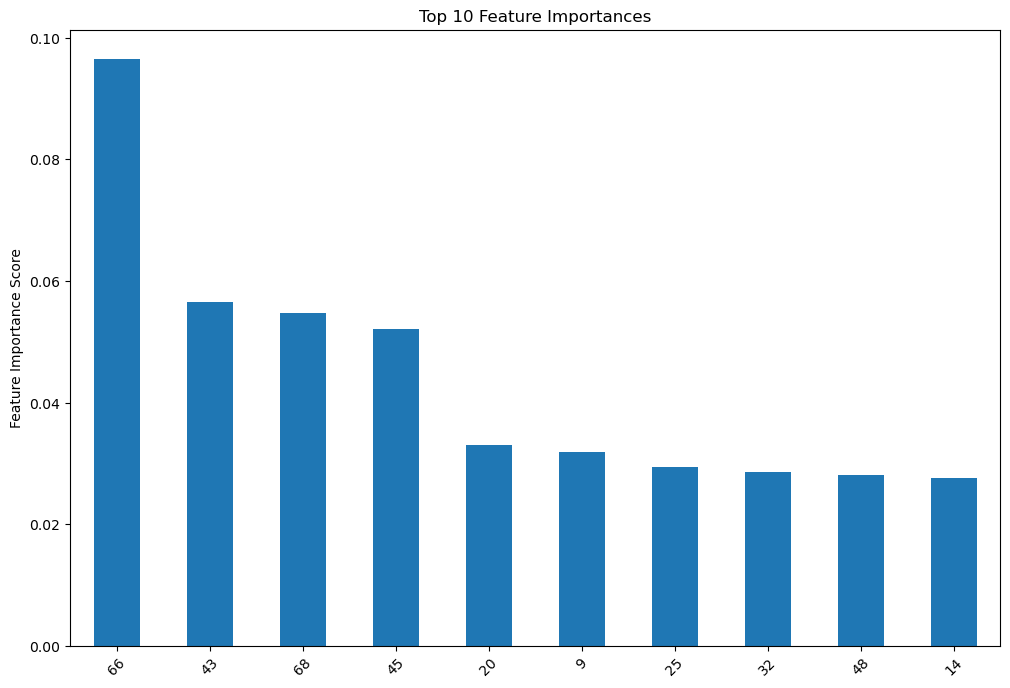

In [8]:
#To train model and make prediction
xgboost = Model(train, test)
prediction, model, redundant = xgboost()

In [9]:
# Prediction of the model above
prediction

array([2, 2, 2, ..., 0, 1, 1])

In [10]:
lithology_numbers = {30000: 0,
                65030: 1,
                65000: 2,
                80000: 3,
                74000: 4,
                70000: 5,
                70032: 6,
                88000: 7,
                86000: 8,
                99000: 9,
                90000: 10,
                93000: 11}


category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction = np.vectorize(category_to_lithology.get)(prediction)
np.savetxt(PWD + 'saved_test_file.csv', test_prediction, header='lithology', fmt='%i')

In [11]:
pred_df = pd.read_csv(f'{PWD}saved_test_file.csv')
pred_df['# lithology'].value_counts()

65000    96851
30000    23723
65030     9285
70000     5023
99000      963
80000      529
90000      397
86000       15
Name: # lithology, dtype: int64

In [12]:
hidden_test = pd.read_csv(PWD + 'hidden_test.csv', sep=';')
hidden_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122397 entries, 0 to 122396
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   WELL                               122397 non-null  object 
 1   DEPTH_MD                           122397 non-null  float64
 2   X_LOC                              122386 non-null  float64
 3   Y_LOC                              122386 non-null  float64
 4   Z_LOC                              122386 non-null  float64
 5   GROUP                              122397 non-null  object 
 6   FORMATION                          114248 non-null  object 
 7   CALI                               118954 non-null  float64
 8   RSHA                               25683 non-null   float64
 9   RMED                               112580 non-null  float64
 10  RDEP                               122386 non-null  float64
 11  RHOB                               1128

shape of concatenated dataframe before dropping columns (1292908, 29)
shape of dataframe after dropping columns (1292908, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1292908, 27)
Splitting concatenated dataframe into training and test datasets...
(1292908, 24)
Shape of train and test datasets BEFORE augmentation ((1170511, 23), (122397, 23))
Shape of train and test datasets AFTER augmentation ((1170511, 92), (122397, 92))


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:36:41] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16136
[99]	validation_0-mlogloss:0.31486
Default score: [-0.27387614]
Accuracy is: 0.8959351399378054
F1 is: 0.8998809307087795
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:37:13] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16229
[99]	validation_0-mlogloss:0.32012
Default score: [-0.27777208]
Accuracy is: 0.8942512238255119
F1 is: 0.898184526259688
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:37:44] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16213
[99]	validation_0-mlogloss:0.31785
Default score: [-0.27635924]
Accuracy is: 0.8947723641831339
F1 is: 0.8987318511523752
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:38:16] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16211
[99]	validation_0-mlogloss:0.31780
Default score: [-0.2754387]
Accuracy is: 0.8953618508171651
F1 is: 0.8991657806308082
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:38:48] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16176
[99]	validation_0-mlogloss:0.31991
Default score: [-0.27945938]
Accuracy is: 0.893866776020709
F1 is: 0.8977272327784337
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:39:19] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16172
[99]	validation_0-mlogloss:0.31863
Default score: [-0.2763571]
Accuracy is: 0.8949176000205039
F1 is: 0.8989049282322668
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:39:51] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16248
[99]	validation_0-mlogloss:0.32000
Default score: [-0.28061059]
Accuracy is: 0.8936959103296853
F1 is: 0.8977527292736892
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:40:23] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16220
[99]	validation_0-mlogloss:0.31762
Default score: [-0.27683552]
Accuracy is: 0.894874883597748
F1 is: 0.8985821544270378
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:40:58] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16224
[99]	validation_0-mlogloss:0.31797
Default score: [-0.27961957]
Accuracy is: 0.8936873670451342
F1 is: 0.8976630898218113
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:41:35] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16220
[99]	validation_0-mlogloss:0.31729
Default score: [-0.2773588]
Accuracy is: 0.894780907467685
F1 is: 0.8985616561505191
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


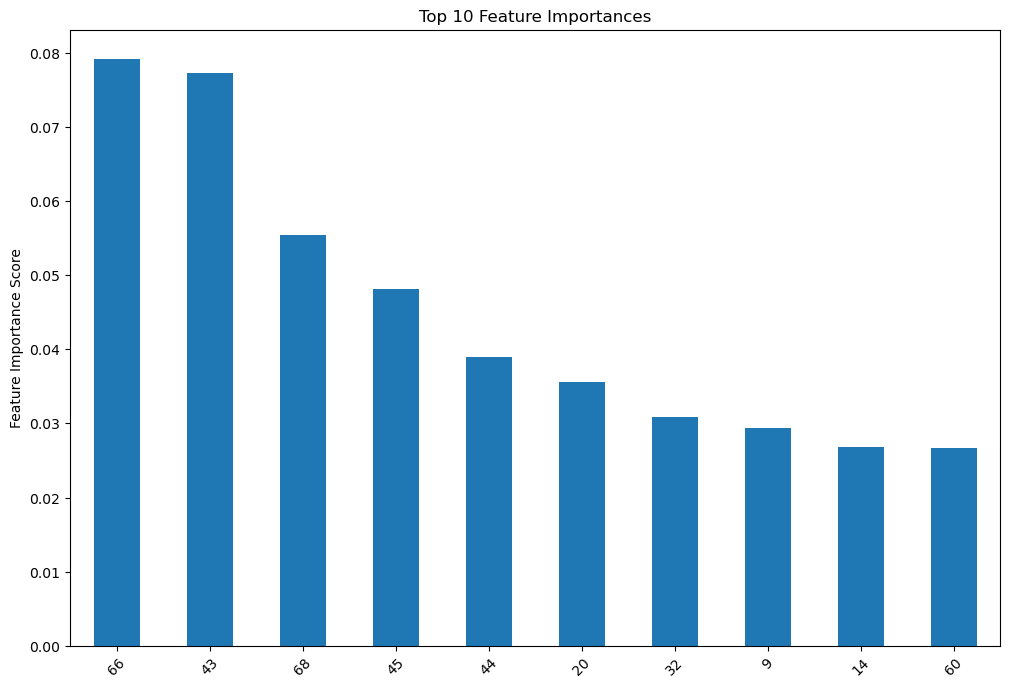

In [13]:
xgboost2 = Model(train, hidden_test)
prediction2, model2, _ = xgboost2()

In [14]:
prediction2

array([2, 2, 2, ..., 1, 1, 2])

In [15]:
category_to_lithology2 = {y:x for x,y in lithology_numbers.items()}
test_prediction2 = np.vectorize(category_to_lithology2.get)(prediction2)
np.savetxt(PWD + 'saved_hidden_test_file.csv', test_prediction2, header='lithology', fmt='%i')

In [16]:
pred_df2 = pd.read_csv(f'{PWD}saved_hidden_test_file.csv')
pred_df2['# lithology'].value_counts()

65000    79446
30000    14386
70000     8624
88000     6538
65030     6274
80000     3909
70032     1276
99000     1130
86000      624
90000      174
74000       16
Name: # lithology, dtype: int64

In [17]:
hidden_test_labels = hidden_test['FORCE_2020_LITHOFACIES_LITHOLOGY']
hidden_test_labels.value_counts()

65000    71827
30000    14045
65030    12283
70000     8374
88000     6498
80000     4396
70032     2905
99000      941
86000      597
74000      287
90000      244
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [18]:
predicted_labels2 = pred_df2['# lithology']
true_labels2 = hidden_test_labels

# Calculate accuracy
accuracy = accuracy_score(true_labels2, predicted_labels2)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(true_labels2, predicted_labels2, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.8075279622866574
F1 Score: 0.7902691902979689


In [19]:
traindata1, testdata1, lithology1, lithology_numbers = xgboost.preprocess(train, test)

shape of concatenated dataframe before dropping columns (1307297, 29)
shape of dataframe after dropping columns (1307297, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1307297, 27)
Splitting concatenated dataframe into training and test datasets...
(1307297, 24)
Shape of train and test datasets BEFORE augmentation ((1170511, 23), (136786, 23))
Shape of train and test datasets AFTER augmentation ((1170511, 92), (136786, 92))


In [20]:
feature_names = pd.DataFrame(traindata1).columns
feature_names.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91])